### Question 6

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import re
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


In [ ]:

DATA_DIR = "Q2/Data/emotion_classification"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
TEST_DIR = os.path.join(DATA_DIR, "test")
IMAGE_SIZE = (100, 100)  # Image resized to 100x100 pixels

def extract_label_from_filename(filename):
    match = re.search(r'\.(happy|sad)\.gif$', filename)
    return match.group(1) if match else None  

def load_data(directory):
    X, y = [], []

    for img_name in tqdm(os.listdir(directory), desc=f"Loading images from {directory}"):
        img_path = os.path.join(directory, img_name)
        
        label = extract_label_from_filename(img_name)
        if label is None:
            continue

        try:
            # Open image using PIL, convert to grayscale
            img = Image.open(img_path).convert("L")  # "L" mode for grayscale
            img = img.resize(IMAGE_SIZE) 
            
            X.append(np.array(img).flatten())
            y.append(label)
        except Exception as e:
            print(f"Warning: Could not process {img_path}. Error: {e}")
            continue  # Skip unreadable images

    return np.array(X), np.array(y)

X_train, y_train = load_data(TRAIN_DIR)
X_test, y_test = load_data(TEST_DIR)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)



Loading images from Q2/Data/emotion_classification\train: 100%|██████████| 20/20 [00:00<00:00, 225.73it/s]
Loading images from Q2/Data/emotion_classification\test: 100%|██████████| 10/10 [00:00<00:00, 243.40it/s]



Training Neural Network with 10 hidden neurons
Epoch 1/20, Loss: 1.3694
Epoch 2/20, Loss: 1.2180
Epoch 3/20, Loss: 1.0891
Epoch 4/20, Loss: 0.9772
Epoch 5/20, Loss: 0.8881
Epoch 6/20, Loss: 0.8230
Epoch 7/20, Loss: 0.7748
Epoch 8/20, Loss: 0.7397
Epoch 9/20, Loss: 0.7154
Epoch 10/20, Loss: 0.7001
Epoch 11/20, Loss: 0.6929
Epoch 12/20, Loss: 0.6875
Epoch 13/20, Loss: 0.6832
Epoch 14/20, Loss: 0.6799
Epoch 15/20, Loss: 0.6770
Epoch 16/20, Loss: 0.6746
Epoch 17/20, Loss: 0.6724
Epoch 18/20, Loss: 0.6704
Epoch 19/20, Loss: 0.6685
Epoch 20/20, Loss: 0.6665
Test Accuracy with 10 hidden neurons: 0.6000
Train Accuracy with 10 hidden neurons: 0.7000

Training Neural Network with 15 hidden neurons
Epoch 1/20, Loss: 0.8192
Epoch 2/20, Loss: 0.6961
Epoch 3/20, Loss: 0.6275
Epoch 4/20, Loss: 0.5842
Epoch 5/20, Loss: 0.5573
Epoch 6/20, Loss: 0.5410
Epoch 7/20, Loss: 0.5308
Epoch 8/20, Loss: 0.5240
Epoch 9/20, Loss: 0.5188
Epoch 10/20, Loss: 0.5145
Epoch 11/20, Loss: 0.5106
Epoch 12/20, Loss: 0.5071

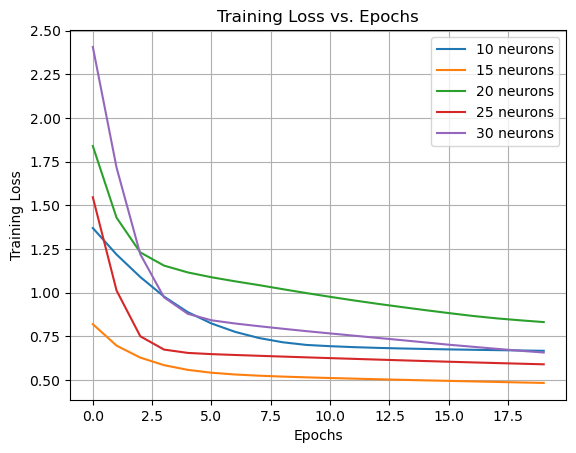

In [ ]:

class PCA_cust:
    def __init__(self,K):
        self.eigvecs = None
        self.K=K
    
    def fit(self, x):
        x = x - np.mean(x, axis=0)  # Center the data
        N = len(x)
        
        # Calculate the covariance matrix
        cov = x @ x.T / N
        
        # Calculate the eigenvalues and eigenvectors
        eigvals, eigvecs = np.linalg.eigh(cov)
        
        # Sort the eigenvectors by decreasing eigenvalues
        idx = np.argsort(np.abs(eigvals))[::-1]
        eigvals = eigvals[idx]
        eigvecs = eigvecs[:, idx]
        
        # Select the first (largest) K eigenvectors
        eigvecs = eigvecs[:, :self.K]
        eigvecs = x.T@eigvecs/np.sqrt(N*eigvals[:self.K])
        # Store eigenvectors
        self.eigvecs = eigvecs
        
    def predict(self, x):
        if self.eigvecs is None:
            raise ValueError("Model is not fitted yet.")
        
        # Project the data onto the eigenvectors
        x_projected = np.dot(x, self.eigvecs)
        return x_projected


def relu(Z):
    return np.maximum(0, Z)

def relu_derivative(Z):
    return (Z > 0).astype(float) 

def softmax(Z):
    expZ = np.exp(Z - np.max(Z, axis=1, keepdims=True))  
    return expZ / np.sum(expZ, axis=1, keepdims=True)

# Loss function: Cross-entropy
def cross_entropy_loss(Y_true, Y_pred):
    m = Y_true.shape[0]
    return -np.sum(Y_true * np.log(Y_pred + 1e-8)) / m  # Adding epsilon for stability

# Neural Network Class
class NeuralNetwork:
    def __init__(self, input_dim, hidden_dim, output_dim, learning_rate=0.001):
        np.random.seed(42)  # For reproducibility
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.01
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.01
        self.b2 = np.zeros((1, output_dim))
        self.learning_rate = learning_rate

    def forward(self, X):
        self.Z1 = np.dot(X, self.W1) + self.b1
        self.A1 = relu(self.Z1)
        self.Z2 = np.dot(self.A1, self.W2) + self.b2
        self.A2 = softmax(self.Z2)
        return self.A2  

    def backward(self, X, Y_true):
        m = X.shape[0]

        #output layer error
        dZ2 = self.A2 - Y_true  
        dW2 = np.dot(self.A1.T, dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        #hidden layer error
        dA1 = np.dot(dZ2, self.W2.T)
        dZ1 = dA1 * relu_derivative(self.Z1)
        dW1 = np.dot(X.T, dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # Gradient Descent update
        self.W1 -= self.learning_rate * dW1
        self.b1 -= self.learning_rate * db1
        self.W2 -= self.learning_rate * dW2
        self.b2 -= self.learning_rate * db2

    def train(self, X_train, Y_train, epochs=20):
        loss_history = []
        for epoch in range(epochs):
            Y_pred = self.forward(X_train)
            loss = cross_entropy_loss(Y_train, Y_pred)
            self.backward(X_train, Y_train)
            loss_history.append(loss)
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss:.4f}")
        return loss_history

    def predict(self, X):
        Y_pred = self.forward(X)
        return np.argmax(Y_pred, axis=1)


def preprocess_data(X_train, y_train, X_test, y_test, K=12):
    pca = PCA_cust(K=K)
    pca.fit(X_train)
    X_train_pca = pca.predict(X_train)
    X_test_pca = pca.predict(X_test)

    encoder = OneHotEncoder(sparse=False)
    y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
    y_test_encoded = encoder.transform(y_test.reshape(-1, 1))

    return X_train_pca, y_train_encoded, X_test_pca, y_test_encoded



hidden_sizes = [10, 15, 20, 25, 30]
X_train_pca, y_train_encoded, X_test_pca, y_test_encoded = preprocess_data(X_train, y_train, X_test, y_test)

for hidden_size in hidden_sizes:
    print(f"\nTraining Neural Network with {hidden_size} hidden neurons")
    nn = NeuralNetwork(input_dim=12, hidden_dim=hidden_size, output_dim=2, learning_rate=1e-5)
    loss_history = nn.train(X_train_pca, y_train_encoded, epochs=20)

    plt.plot(loss_history, label=f"{hidden_size} neurons")

    # Compute accuracy
    y_pred = nn.predict(X_test_pca)
    accuracy = np.mean(y_pred == np.argmax(y_test_encoded, axis=1))
    print(f"Test Accuracy with {hidden_size} hidden neurons: {accuracy:.4f}")
    y_pred_train = nn.predict(X_train_pca)
    accuracy = np.mean(y_pred_train == np.argmax(y_train_encoded, axis=1))
    print(f"Train Accuracy with {hidden_size} hidden neurons: {accuracy:.4f}")

plt.xlabel("Epochs")
plt.ylabel("Training Loss")
plt.title("Training Loss vs. Epochs")
plt.legend()
plt.grid(True)
plt.show()


We plot the training losses with epochs, and observe for all neurons, they converge by around 13 epochs.
The best testing accuracy is obtained for 15 neurons, with a 90% testing accuracy.

The test accuracy using 10 neurons is 60%, which increases to 90% with 15 neurons. The test accuracy decreases to 40% with 20 neurons, and then increases to 60% using 30 neurons.